<a href="https://colab.research.google.com/github/LuckyLucario/ProjetoDLT/blob/main/avaliacaodealgoritmosdeAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integrantes do grupo
**Daniel Kenichi Tiago Tateishi** RA:790837

**João Dini de Miranda** RA: 790716

## Etapa 1 a 5
Selecionamos o conjunto de dados [Breast Cancer Wisconsin (Diagnostic)](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)). 

O conjunto está disponível em `sklearn.datasets`. 

Fazemos a conversão do conjunto de dados para um DataFrame do Pandas para melhor visualização e tratamento dos dados.

Os atributos nominais do conjunto "Maligno" e "Benigno" já estão no formato binário e portanto não necessitam de conversão.

In [ ]:
# Importando bibliotecas utilizadas
import numpy as np
import pandas as pd
import statistics
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.datasets import load_breast_cancer
from matplotlib import pyplot as plt

# Ignorando warnings 
import warnings
warnings.filterwarnings('ignore')

# Carregando o banco de dados utilizado
breast_cancer = load_breast_cancer()
X = breast_cancer.data
Y = breast_cancer.target

# Convertendo o dataset para DataFrame do Pandas
data = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
data['class'] = breast_cancer.target
Y = data['class']   
X = data.drop('class', axis=1)  

data #Exibindo dados

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


## Etapa 6

Após isso, dividimos o dataframe em 10 "folds" para poder dividir os dados em dados de treinamento e dados de teste.

---

Para realizar a divisão, verificamos o tamanho mínimo de cada fold em `mfold_size`, e quantas amostras sobrariam caso dividissemos os folds com exatamente o mesmo tamanho e armazenamos esse valor em `r`. Dessa forma, conseguimos gerar os folds com a distribuição das sobras previamente calculada (para os folds com posição menor que `k - r`, recebem o tamanho mínimo, para folds com index maior que `k - r`, é feito a distribuição das amostras que sobraram).

Por exemplo, se fossemos dividir 14 amostras em 10 folds, teriamos um conjunto de folds em que o tamanho de cada fold seria representado pelo conjunto [1, 1, 1, 1, 1, 1, 2, 2, 2, 2].

In [ ]:
# Número de folds
k = 10 
# Restante a ser redistribuido nos folds
r = len(data.index)%k
# Tamanho mínimo de um fold
mfold_size = (len(data.index) // k)
pos = 0
folds = []
for i in range(k):
  if i < k - r:
    folds.append(data.iloc[pos : pos + mfold_size, :])
  else:
    folds.append(data.iloc[pos : pos + mfold_size + 1, :])
  pos += mfold_size
      
#print(folds) # Imprimir folds gerados

## Etapa 7 e 8
Agora com os folds gerados, vamos avaliar um algoritmo de indução de árvores de decisão usando a estratégia 10-fold cross-validation.

Usamos a função `fit()` para obter o "estimador" gerado pelo o algoritmo.



In [ ]:
# Resultado de cada iteração
clfs = []    

# Conjunto X (Treino/Teste)
X_train = [] 
X_test = []

# Conjunto Y (Treino/Teste)
Y_train = [] 
Y_test = []

# Cada iteração avalia o algoritmo em uma variação de Treino/Teste usando os folds
for i in range(k):
  # Obtendo e armazenando os conjuntos de treino/teste dessa iteração
  test = folds[i]
  train = pd.DataFrame(None)
  for j in range(k):
    if j != i:
      train = pd.concat([train, folds[j]], ignore_index = True, axis = 0)

  Y_test.append(test['class'])
  Y_train.append(train['class'])
  X_train.append(train.drop('class', axis = 1))
  X_test.append(test.drop('class', axis = 1))

  # Treinando o algoritmo
  clf = tree.DecisionTreeClassifier(criterion='entropy')
  # Adicionando o resultado à lista de resultados
  clfs.append(clf.fit(X_train[i], Y_train[i]))




## Etapa 9
Gerando a figura da árvore de decisão de uma das iterações do cross-fold

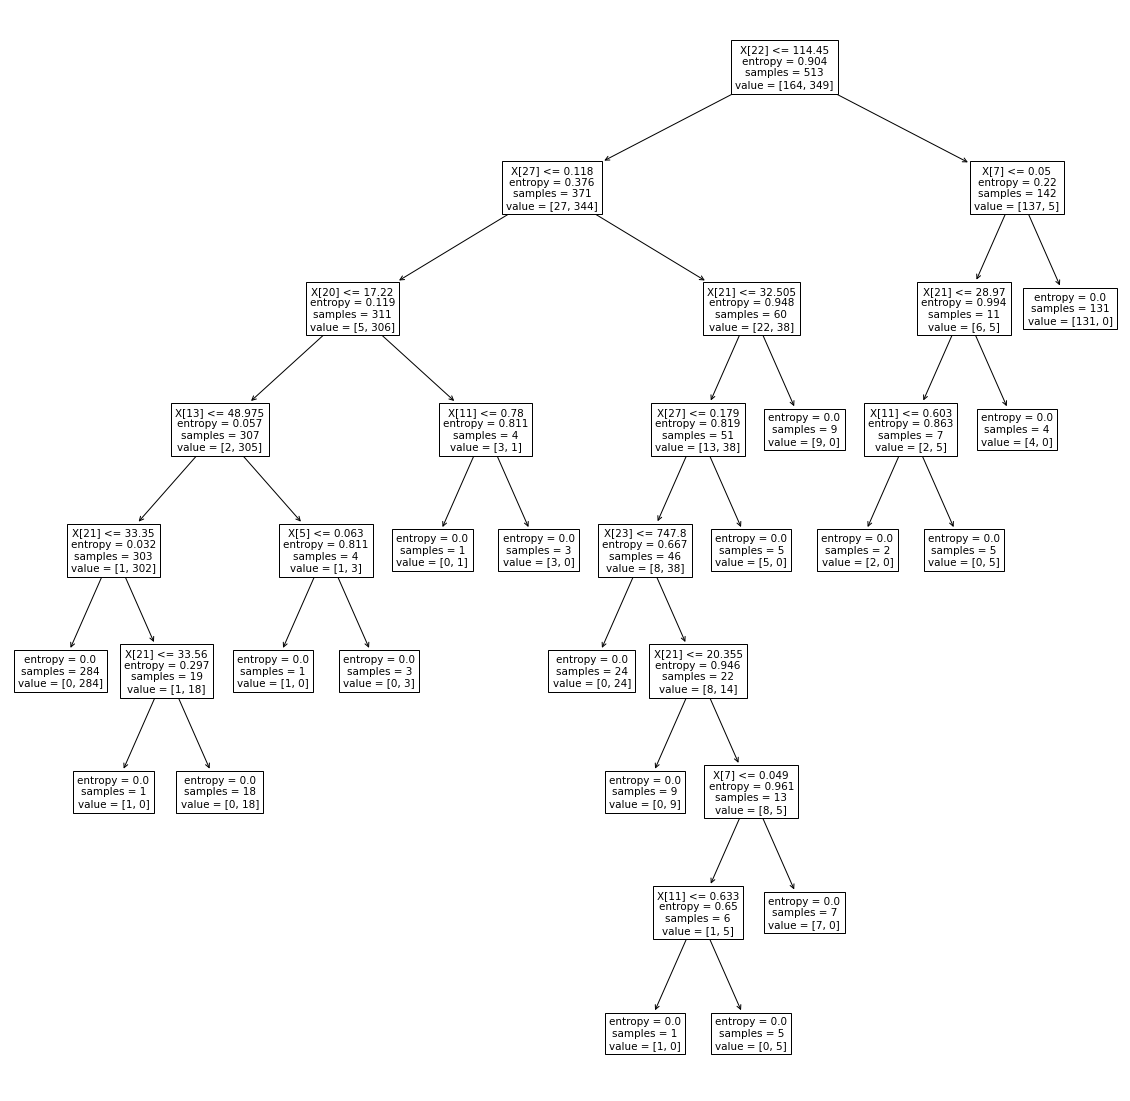

In [ ]:
fig = plt.figure(figsize=(20,20))
fig = tree.plot_tree(clfs[0])

## Etapa 10 e 11

Para cada iteração do algoritmo, fazemos a classificação dos seus dados de teste usando `.predict()`

Ao mesmo tempo, calculamos para essa iteração a matriz de confusão (`confusion_matrix()`) e o relatório da classificação (`classification_report()`) que podem ser vistos impressos a seguir.

Matrizes de confusão e relatórios individuais


🡆🡆 0 🡄🡄



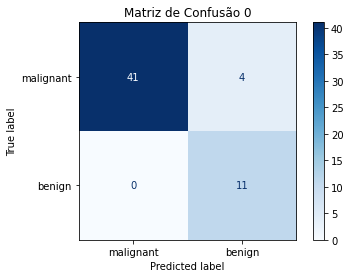


Relatório da classificação 0: 

              precision    recall  f1-score    support
0              1.000000  0.911111  0.953488  45.000000
1              0.733333  1.000000  0.846154  11.000000
accuracy       0.928571  0.928571  0.928571   0.928571
macro avg      0.866667  0.955556  0.899821  56.000000
weighted avg   0.947619  0.928571  0.932405  56.000000


🡆🡆 1 🡄🡄



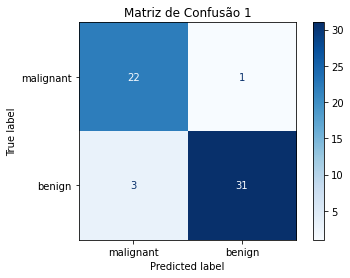


Relatório da classificação 1: 

              precision    recall  f1-score    support
0              0.880000  0.956522  0.916667  23.000000
1              0.968750  0.911765  0.939394  34.000000
accuracy       0.929825  0.929825  0.929825   0.929825
macro avg      0.924375  0.934143  0.928030  57.000000
weighted avg   0.932939  0.929825  0.930223  57.000000


🡆🡆 2 🡄🡄



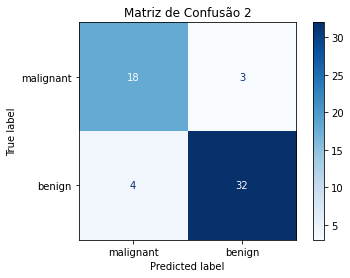


Relatório da classificação 2: 

              precision    recall  f1-score    support
0              0.818182  0.857143  0.837209  21.000000
1              0.914286  0.888889  0.901408  36.000000
accuracy       0.877193  0.877193  0.877193   0.877193
macro avg      0.866234  0.873016  0.869309  57.000000
weighted avg   0.878879  0.877193  0.877756  57.000000


🡆🡆 3 🡄🡄



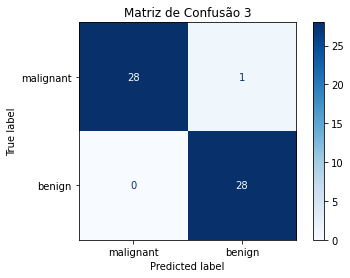


Relatório da classificação 3: 

              precision    recall  f1-score    support
0              1.000000  0.965517  0.982456  29.000000
1              0.965517  1.000000  0.982456  28.000000
accuracy       0.982456  0.982456  0.982456   0.982456
macro avg      0.982759  0.982759  0.982456  57.000000
weighted avg   0.983061  0.982456  0.982456  57.000000


🡆🡆 4 🡄🡄



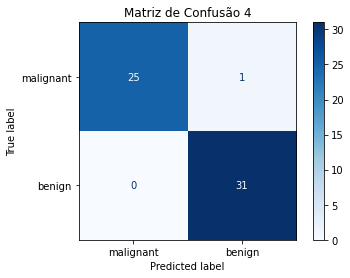


Relatório da classificação 4: 

              precision    recall  f1-score    support
0              1.000000  0.961538  0.980392  26.000000
1              0.968750  1.000000  0.984127  31.000000
accuracy       0.982456  0.982456  0.982456   0.982456
macro avg      0.984375  0.980769  0.982260  57.000000
weighted avg   0.983004  0.982456  0.982423  57.000000


🡆🡆 5 🡄🡄



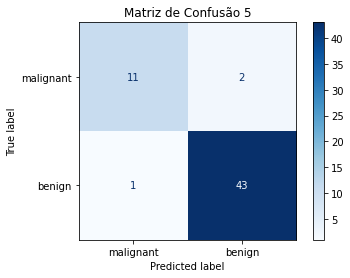


Relatório da classificação 5: 

              precision    recall  f1-score    support
0              0.916667  0.846154  0.880000  13.000000
1              0.955556  0.977273  0.966292  44.000000
accuracy       0.947368  0.947368  0.947368   0.947368
macro avg      0.936111  0.911713  0.923146  57.000000
weighted avg   0.946686  0.947368  0.946611  57.000000


🡆🡆 6 🡄🡄



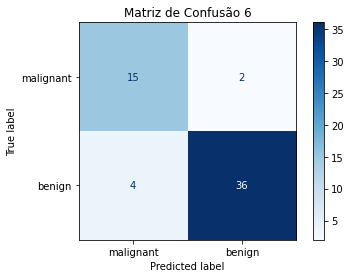


Relatório da classificação 6: 

              precision    recall  f1-score    support
0              0.789474  0.882353  0.833333  17.000000
1              0.947368  0.900000  0.923077  40.000000
accuracy       0.894737  0.894737  0.894737   0.894737
macro avg      0.868421  0.891176  0.878205  57.000000
weighted avg   0.900277  0.894737  0.896311  57.000000


🡆🡆 7 🡄🡄



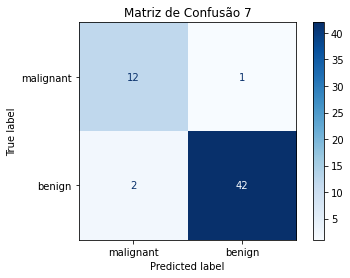


Relatório da classificação 7: 

              precision    recall  f1-score    support
0              0.857143  0.923077  0.888889  13.000000
1              0.976744  0.954545  0.965517  44.000000
accuracy       0.947368  0.947368  0.947368   0.947368
macro avg      0.916944  0.938811  0.927203  57.000000
weighted avg   0.949467  0.947368  0.948041  57.000000


🡆🡆 8 🡄🡄



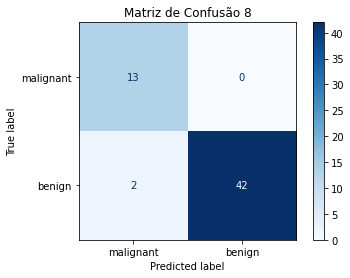


Relatório da classificação 8: 

              precision    recall  f1-score    support
0              0.866667  1.000000  0.928571  13.000000
1              1.000000  0.954545  0.976744  44.000000
accuracy       0.964912  0.964912  0.964912   0.964912
macro avg      0.933333  0.977273  0.952658  57.000000
weighted avg   0.969591  0.964912  0.965757  57.000000


🡆🡆 9 🡄🡄



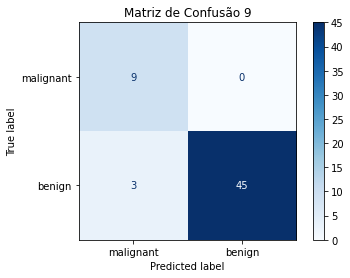


Relatório da classificação 9: 

              precision    recall  f1-score    support
0              0.750000  1.000000  0.857143   9.000000
1              1.000000  0.937500  0.967742  48.000000
accuracy       0.947368  0.947368  0.947368   0.947368
macro avg      0.875000  0.968750  0.912442  57.000000
weighted avg   0.960526  0.947368  0.950279  57.000000


In [ ]:
print("Matrizes de confusão e relatórios individuais")
class_reports = [] # Lista dos relatórios de classificação

for i in range(k):  
  print(f"\n\n🡆🡆 {i} 🡄🡄\n")

  # Classificação dos algoritmos com o conjunto de testes
  predicted = clfs[i].predict(X_test[i])

  # Gerando matriz de confusão
  class_names = breast_cancer.target_names
  title = f"Matriz de Confusão {i}"
  disp = plot_confusion_matrix(clfs[i], X_test[i], Y_test[i], display_labels=class_names, cmap=plt.cm.Blues)
  disp.ax_.set_title(title)
  plt.show()
  
  # Gerando relatórios da classificação
  cr = classification_report(Y_test[i], predicted, output_dict=True)
  class_reports.append(pd.DataFrame(cr).transpose()) # Convertendo para DataFrames

  print(f"\nRelatório da classificação {i}: \n") 
  print(class_reports[i])
 

## Etapa 12
Calculando a média e o desvio padrão dentre as diferentes iterações do algoritmo.

Para cada campo do relatório da classificação calculamos a média e o desvio padrão.

In [ ]:
# Usando dataframe como base para os novos
media_df = class_reports[0].copy()
desvio_df = class_reports[0].copy()

# Seleciona o campo do relatório
for i in range(len(class_reports[0])):
  for j in range(len(class_reports[0].columns)):
    # Percorre os relatórios, na mesma posição e adiciona em uma lista
    valores_ij = []
    for cr in class_reports:
      valores_ij.append(cr.iloc[i][j])
    # Calcula Média e Desvio Padrão
    media_df.iloc[i][j] = statistics.mean(valores_ij)
    desvio_df.iloc[i][j] = statistics.pstdev(valores_ij)

# Exibindo Média e Desvio Padrão
print("Média")
print(media_df)
print()
print("Desvio Padrão")
print(desvio_df)

Média
              precision    recall  f1-score    support
0              0.887813  0.930342  0.905815  20.900000
1              0.943030  0.952452  0.945291  36.000000
accuracy       0.940226  0.940226  0.940226   0.940226
macro avg      0.915422  0.941397  0.925553  56.900000
weighted avg   0.945205  0.940226  0.941226  56.900000

Desvio Padrão
              precision    recall  f1-score    support
0              0.085762  0.052699  0.052561  10.103960
1              0.073777  0.040097  0.041851  10.344080
accuracy       0.032582  0.032582  0.032582   0.032582
macro avg      0.043312  0.036926  0.036664   0.300000
weighted avg   0.032071  0.032582  0.032251   0.300000
